<a href="https://colab.research.google.com/github/donatelk/kgdneuro265/blob/main/statistics_02_26_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistics for Neuroscientists

This notebook will discuss **descriptive** and **inferential** statistics, and introduce ways to implement them in Python.

### By the end of this notebook, you will be able to:

* Identify when to use descriptive or inferential statistics
* Apply the appropriate statistical tests to compare two groups
* Use the stats package from SciPy to run simple tests in Python
* Test e-phys metrics between different interneuron types




## Part One: Population vs sample distributions

**Descriptive statistics** summarize the main features of a data set.

It's important to distinguish between the following:

* **Observation**: result from one trial of an experiment (like one ISI)
* **Sample**: results from multiple independent trials (all ISIs)
* **Population**: the *ground truth*; all possible ISIs that could be seen

Distributions differ in their **location** (mean, $\\mu$) and **spread** (standard deviation, $\\sigma$). Below, we'll define a **population distribution** and plot it.

In [ ]:
# Import our necessary toolboxes and tell matplotlib to plot inline
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Decide on a mean and a standard deviation
mu, sigma = 3, 2

# Use np.random.normal to create a distribution of 10,000 points with our given mu & sigma
pop = np.random.normal(mu, sigma, 10000)

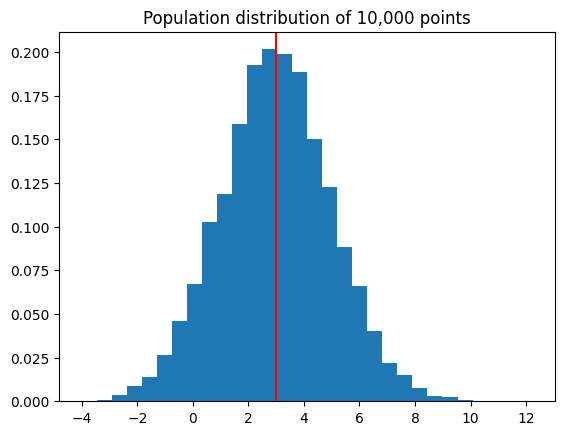

In [ ]:
# Plot a histogram with 30 bins
# Giving it the argument density=True will plot normalized counts
# This will create a probability density (rather than raw counts)
plt.hist(pop, 30, density=True)
plt.axvline(mu,color='r')
plt.title('Population distribution of 10,000 points')
plt.show()

There are various ways we can describe the distribution of the dataset, beyond the standard deviation:

* Range (minimum and maximum)
* Variance ($\\sigma^2$)
* Standard Error of the Mean (S.E.M., $\\sigma/\\sqrt{n}$)
* Confidence Intervals

We can easily get many of these descriptive statistics by using the `scipy stats` package method `describe()`. [Documentation here.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.describe.html)

In [ ]:
from scipy import stats

stats.describe(pop)

DescribeResult(nobs=np.int64(10000), minmax=(np.float64(-4.001269997612841), np.float64(12.23624595607514)), mean=np.float64(2.995321548049429), variance=np.float64(3.975958374275336), skewness=np.float64(0.05504273385741728), kurtosis=np.float64(0.055105298639014144))

We created a normal distribution from a mean of 3 but with limited points, so these values are *just* slightly off. You'll also notice that the variance is indeed our standard deviation (2) squared.

Our variable `pop` is the \"ground truth\" population. However, we'll rarely have *10,000* datapoints in our sample. So, let's generate a more realistic sample, and see how the mean compares.

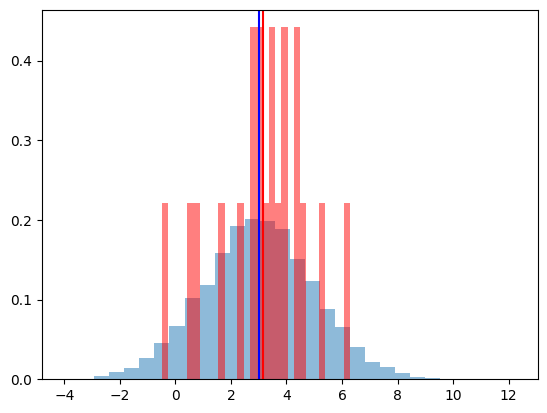

In [ ]:
# Create a sample distribution with less data points
sample_mean, sample_sigma = 3, 2
sample = np.random.normal(sample_mean, sample_sigma, 20)

# Plot our histogram, with alpha to 0.5 which will make the chart slightly transparent
plt.hist(pop, 30, alpha=0.5, density=True)
plt.hist(sample, 30, alpha=0.5, color='r',density=True)
plt.axvline(np.mean(pop),color='blue') # Take the mean and plot a vertical blue line
plt.axvline(np.mean(sample),color='red') # Take the mean and plot a vertical red line
plt.show()

In [ ]:
# Look at the descriptive statistics of our sample
print(stats.describe(sample))

DescribeResult(nobs=np.int64(20), minmax=(np.float64(-0.4854391177231965), np.float64(6.305748087353809)), mean=np.float64(3.1650552610456097), variance=np.float64(2.664006954834547), skewness=np.float64(-0.441335924816696), kurtosis=np.float64(0.05192483622711652))


## Part Two: The Central Limit Theorem

With fewer samples, the mean of the sample distribution tends to be further from the mean of the population distribution. This is known as the **central limit theorem**, which states that the distribution of sample means will become increasingly close to a normal distribution as the sample size increases, regardless of the shape of the population distribution.

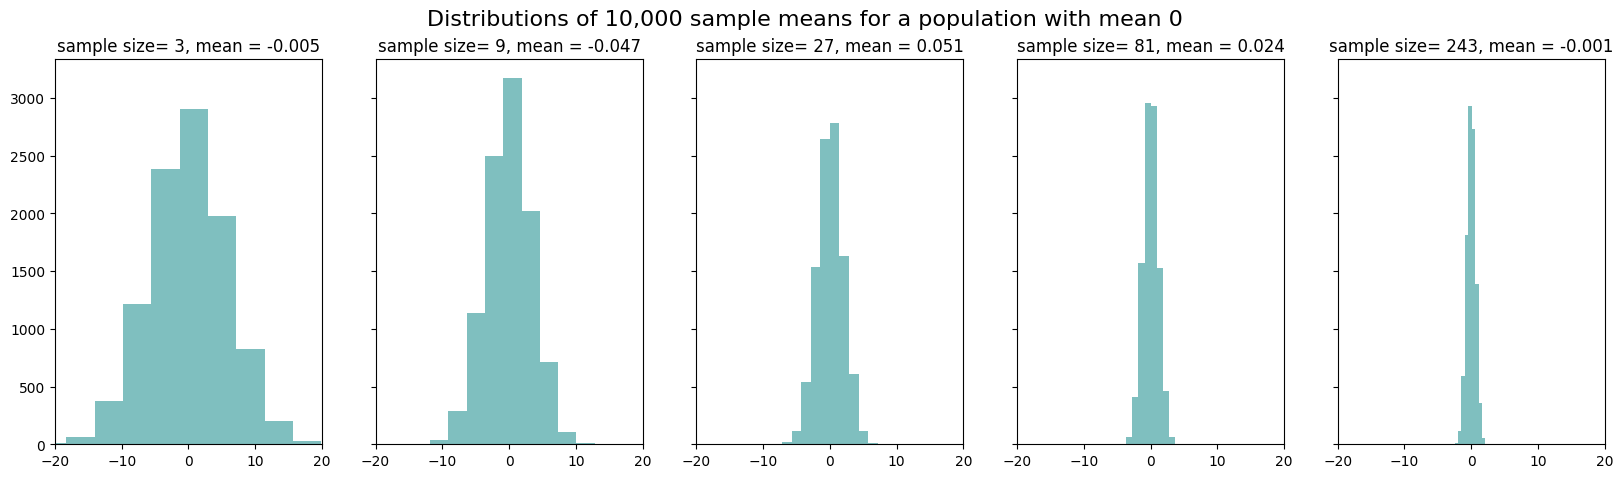

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,5),sharey=True)

mu = 0

sample_means = []

# For each subplot, create a plot.
for a in range(len(ax)):

    # Make the sample size = to 3^(a+1)
    sample_size = 3**(a+1)

    # Calculate the mean of sample of sample_size designated above, 10000 times
    for x in range(10000):
        sample_dist = np.random.normal(mu, 10, sample_size) # Create a normal distribution with mu, sigma
        sample_means.append(np.mean(sample_dist)) # Append the mean of this distribution

    ax[a].hist(sample_means,color='teal',alpha = .5) # Plot the distribution of means
    ax[a].set_title('sample size= '+ str(sample_size)+', mean = '+ str(np.round(np.mean(sample_means),3)))
    ax[a].set_xlim([-20,20])
    sample_means = [] # Reset the sample means

plt.suptitle('Distributions of 10,000 sample means for a population with mean '+str(mu),fontsize=16)

plt.show()

## Part Three: Skewed Distributions

However, not every population in nature is **normally distributed**. In fact, most populations are slightly skewed. Let's demonstrate a population distribution and sample distribution that is drawn from a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution).

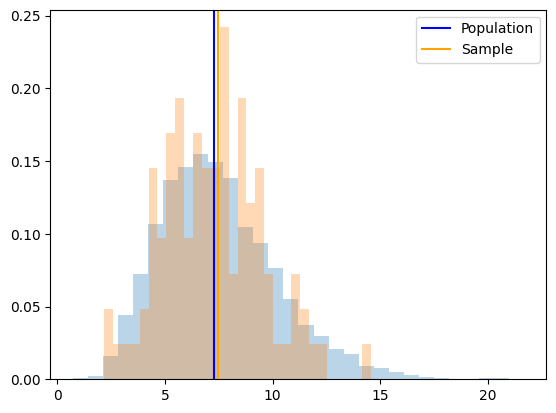

In [ ]:
# Create a skewed distribution of 10,000 points with our given mu & sigma
pop_size = 10000
sample_size = 100

skewed_pop = np.random.gamma(7.5,1,pop_size)
skewed_sample = np.random.gamma(7.5,1,sample_size)

pop_stats = stats.describe(skewed_sample)
sample_stats = stats.describe(skewed_pop)

plt.hist(skewed_pop, 30, alpha = .3, density=True)
plt.hist(skewed_sample, 30, alpha = .3, density=True)
plt.axvline(pop_stats.mean,color='blue')
plt.axvline(sample_stats.mean,color='orange') # plot the mean of the sample

plt.legend(['Population','Sample'])

plt.show()

You might notice that with this skewed population, the mean is a pretty poor descriptor of both distributions. **When the skew is bad (*statistically bad*), we should report the median.**



### Important notes:

* <code>stats.describe()</code> doesn't give us the median (annoyingly) but `np.median()` can!
* The `stats.skewtest()` method ([documentation here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html#scipy.stats.skewtest)) implements the [D'Agostino-Pearson skewness test](https://www.jstor.org/stable/2684359?seq=1), one of many different tests (e.g., the Kolmogorov-Smirov test) that can be used to check the normality of a distribution.
* This code can return a statistic as well as a pvalue, if you designate it.

><b>Task:</b>
1. Rework the code directly above so that if the skew is significant (you can use <code>stats.skewtest()</code> for that!), plot and report the <b>median</b> instead of the mean.
2. Rework our demonstration of the central limit theorem for a skewed, rather than a normal, population. Does the theorem still hold?

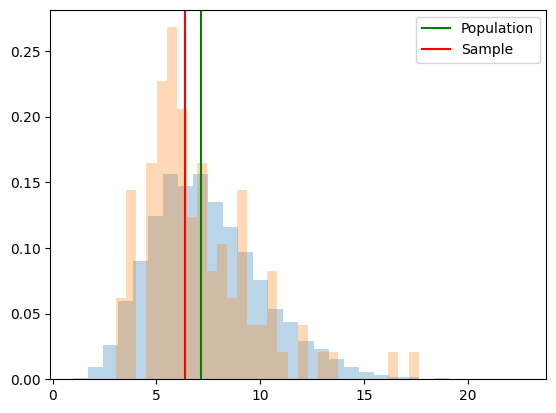

In [ ]:
# Report the median instead of the mean if the skew is significant
pop_size = 10000
sample_size = 100

skewed_pop = np.random.gamma(7.5,1,pop_size)
skewed_sample = np.random.gamma(7.5,1,sample_size)

skew= stats.skewtest(skewed_sample)

pop_stats = stats.describe(skewed_sample)
sample_stats = stats.describe(skewed_pop)

if skew.pvalue < 0.05:
  plt.hist(skewed_pop, 30, alpha = .3, density = True)
  plt.hist(skewed_sample, 30, alpha = .3, density = True)
  plt.axvline(np.median(skewed_pop), color = 'green')
  plt.axvline(np.median(skewed_sample), color = 'red')
else:
  plt.hist(skewed_pop, 30, alpha = .3, density=True)
  plt.hist(skewed_sample, 30, alpha = .3, density=True)
  plt.axvline(pop_stats.mean,color='blue')
  plt.axvline(sample_stats.mean,color='orange') # plot the mean of the sample

plt.legend(['Population','Sample'])

plt.show()

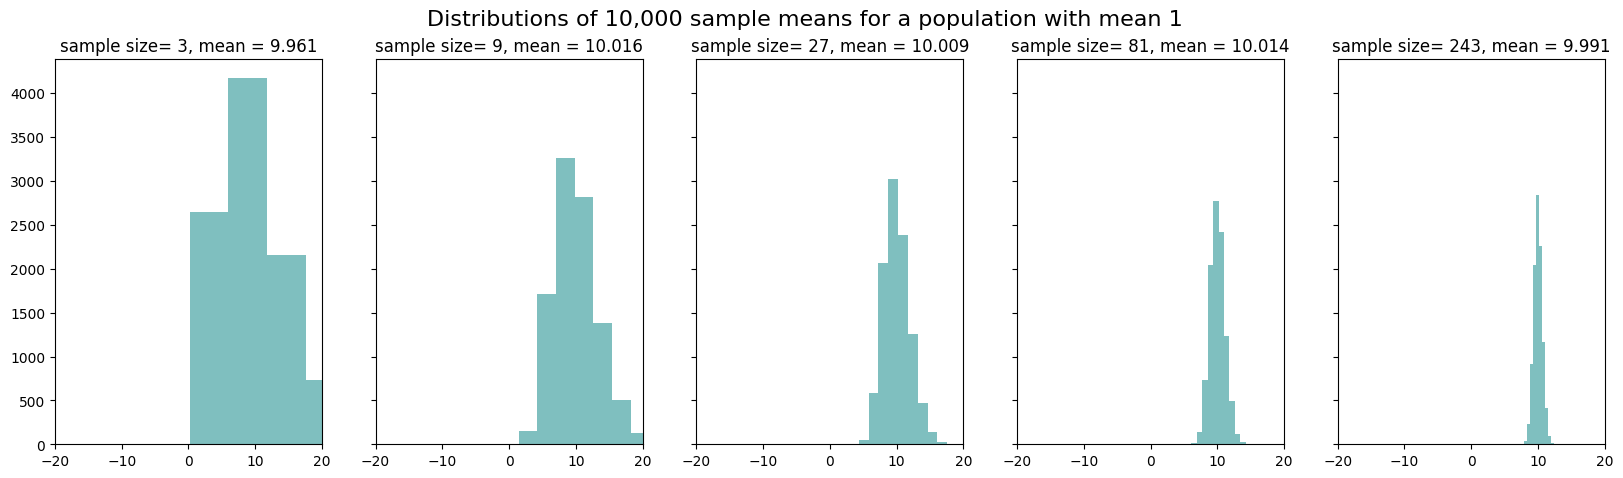

In [ ]:
#Rework central limit therom for a skewed population
fig,ax = plt.subplots(1,5,figsize=(20,5),sharey=True)

mu = 1

sample_means = []

# For each subplot, create a plot.
for a in range(len(ax)):

    # Make the sample size = to 3^(a+1)
    sample_size = 3**(a+1)

    # Calculate the mean of sample of sample_size designated above, 10000 times
    for x in range(10000):
        sample_dist = np.random.gamma(mu, 10, sample_size) # Create a skewed distribution with mu, sigma
        sample_means.append(np.mean(sample_dist)) # Append the mean of this distribution

    ax[a].hist(sample_means,color='teal',alpha = .5) # Plot the distribution of means
    ax[a].set_title('sample size= '+ str(sample_size)+', mean = '+ str(np.round(np.mean(sample_means),3)))
    ax[a].set_xlim([-20,20])
    sample_means = [] # Reset the sample means

plt.suptitle('Distributions of 10,000 sample means for a population with mean '+str(mu),fontsize=16)

plt.show() #The therom still works once the mu is changed to 1

## Part Four: Hypothesis Testing

**Inferential statistics** generalize from observed data to the world at large

Most often, the goal of our hypothesis testing is to test whether or not two distributions are different, or if a distribution has a different mean than the underlying population distribution.

With the normal sample population we generated above, our **null hypothesis** is that the mean of our sample distribution is equal to 3. We want to test the probability that this is not true. Since we know our distributions are normal (they're generated from a normal distribution!) we can use **parametric statistics** to test our hypothesis.

The SciPy stats package has [many hypothesis testing tools](https://docs.scipy.org/doc/scipy/reference/stats.html) (see Statistical Tests). First, we can use a one-way t-test to ask whether our population has a mean different than three.

In [ ]:
sample_mean, sample_sigma = 3, 2
sample_pop = np.random.normal(sample_mean, sample_sigma, 20)
stats.ttest_1samp(sample_pop,3)

TtestResult(statistic=np.float64(-0.9795137624493957), pvalue=np.float64(0.33963467362707145), df=np.int64(19))

Not surprisingly, if we create a normal distribution of mean 3, the distribution is not likely to be different than 3. However, what happens if we change the mean, standard deviation, or sample size?

In most cases, we will be testing whether or not two distributions are different from eachother. In order to do so, we can use the independent t-test in our stats package: `stats.ttest_ind()`. If we had paired samples, we would use a dependent t-test [as seen here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel).

In [ ]:
# Create two distributions and test whether they're different
pop_1 = np.random.normal(3,2,20)
pop_2 = np.random.normal(5,2,20)

stats.ttest_ind(pop_1,pop_2)

TtestResult(statistic=np.float64(-1.659469087851055), pvalue=np.float64(0.10525340262688178), df=np.float64(38.0))

If one of our populations is skewed, however, we **cannot use a t-test**. A t-test assumes that the populations are normally distributed. For skewed populations, we can use either the [Mann-Whitney U](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu) (for independent samples, `stats.mannwhitneyu()`) or the [Wilcoxon Signed Rank Test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon) (for dependent/paired samples,`stats.wilcoxon()`).

In [ ]:
skewed_pop = np.random.gamma(7.5,1,10000)
comparison_pop = np.random.normal(8,2,20)

stats.mannwhitneyu(skewed_pop,comparison_pop)

MannwhitneyuResult(statistic=np.float64(72299.0), pvalue=np.float64(0.03207922082995005))

## Part Five: Comparing fast trough values in our Patch Seq dataset

Let's work with some real data to apply what we've learned above. Below, import your <code>patch_seq_expanded</code> dataset as a Pandas dataframe called <code>patch_seq</code>.

In [ ]:
# Your code here!
import pandas as pd
patch_seq_url= 'https://raw.githubusercontent.com/hallockh/neur_265_spring2026/refs/heads/main/data/patch_seq_expanded.csv'
patch_seq= pd.read_csv(patch_seq_url)

><b>Task</b>: Create a plot with two subplots. The left should be a histogram of our fast trough values ('Fast_Trough') for 'Sst' and 'Pvalb' cells. The right should be a boxplot of the fast trough values ('Fast_Trough'). You can create a histogram of one column of a <code>dataframe</code> by using the syntax <code>df['column_name']</code>.

#This is how far we got in class

In [ ]:
# Your code here! Start with defining your subplot axes

# Next, make your histogram (see code cell in part three of this notebook for an example of how to make overlapping histograms)

# Next, make your boxplot (see our notebook from Tuesday!)

><b>Task</b>: Determine whether these two samples of fast trough values are statistically different! Write code that first checks whether or not the distributions are skewed, and then runs the appropriate statistics.

In [ ]:
# Your code here

><b>Task</b>: Re-create a scatterplot of ISI values vs. Fast Trough values for 'Sst' and 'Pvalb' neurons, with 'Sst' neurons in blue, and 'Pvalb' neurons in red (*hint:* look at our notebook on plotting from Tuesday!) Run linear regressions on each group of interneurons do see whether the associations are statistically significant!

In [ ]:
# Import the linear regression toolbox from scipy

from scipy.stats import linregress

# Create your scatter plot!

marker_types = patch_seq['Marker'].unique()

# Run linear regressions on the two variables!

for m_type in marker_types:

  df = patch_seq[patch_seq['Marker'] == m_type]

  slope, intercept, r, p, stderr = linregress(df['ISI'], df['Fast_Trough'])

  print(f"\n{m_type}")
  print(f"Slope: {slope}")
  print(f"R^2: {r**2}")
  print(f"p-value: {p}")
